In [1]:
# Install packages
# %pip install networkx
# %pip install numpy
# %pip install tqdm
# %pip install matplotlib

In [2]:
# The starter code is short and simple, take a look!
from starter import *
import random

# Phase 1 - Create Inputs

In [3]:
# Add edges with G.add_edge(u, v, weight=w)
# Idea: consider making the inputs with a solution in mind, 
# such that you know the solution when the outputs are released

def np_int32_to_int(G: nx.Graph):
    for u, v, d in G.edges(data=True):
        d['weight'] = int(d['weight'])

def random_generate(G: nx.Graph):
    edges = []
    for u in range(G.number_of_nodes()):
        for v in range(u + 1, G.number_of_nodes()):
            edges.append((u, v))
    random.shuffle(edges)
    for u, v in edges[:min(MAX_EDGES, len(edges))]:
        if u == v:
            continue
        G.add_edge(u, v, weight=random.randint(1, MAX_WEIGHT))
    while sum(d for u, v, d in G.edges(data='weight')) < MIN_NET_WEIGHT:
        u, v = random.randint(0, G.number_of_nodes() - 1), random.randint(0, G.number_of_nodes() - 1)
        if u == v:
            continue
        G.add_edge(u, v, weight=random.randint(1, MAX_WEIGHT))
    np_int32_to_int(G)

def small(G: nx.Graph):
    random_generate(G)

def medium(G: nx.Graph):
    random_generate(G)

def large(G: nx.Graph):
    random_generate(G)

In [4]:
G = nx.empty_graph(N_SMALL)
small(G)
write_input(G, '../tests/small/random/')

G = nx.empty_graph(N_MEDIUM)
medium(G)
write_input(G, '../tests/medium/random/')

G = nx.empty_graph(N_LARGE)
large(G)
write_input(G, '../tests/large/random/')

# Phase 2 - Implement your Solver

In [5]:
def copy_teams(G: nx.Graph, G_copy: nx.Graph):
    for v in G:
        G.nodes[v]['team'] = G_copy.nodes[v]['team']

def random_solve(G: nx.Graph):
    G_best, best_score = G.copy(), float('inf')
    for _ in range(1000):
        G_copy = G.copy()
        for v in G_copy:
            G_copy.nodes[v]['team'] = random.randint(1, random.randint(1, 10))
        curr_score = score(G_copy)
        if curr_score < best_score:
            copy_teams(G_best, G_copy)
            best_score = curr_score
    copy_teams(G, G_best)

def solve(G: nx.Graph):
    random_solve(G)

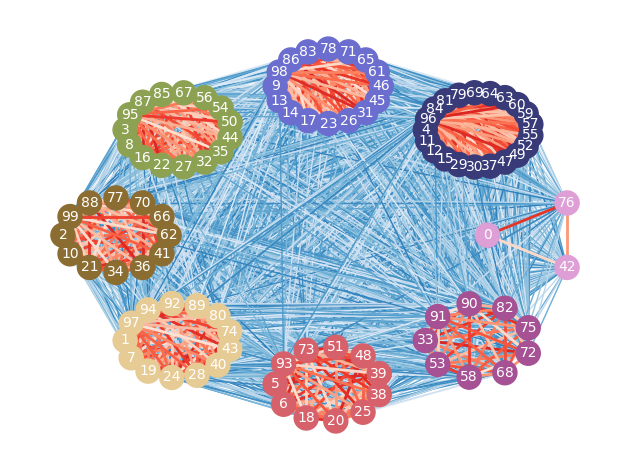

368020.55993114295

In [6]:
IN_FILE = '../tests/small/random_1/'

def score_to_str(score: float):
    return str(round(score))

G = read_input(IN_FILE + '/graph.in')
solve(G)
validate_output(G)
visualize(G)
write_output(G, IN_FILE + '{}.out'.format(score_to_str(score(G))))
score(G)

In [ ]:
run_all(solve, 'input', 'output')
tar('output')

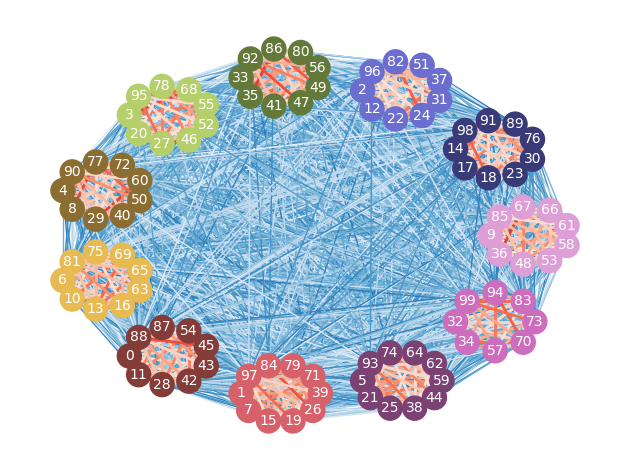

132760.49323151432

In [4]:
########################################
# read our c++ solution and display it #
########################################

SCORE = 132760
FOLDER = '../tests/small/random_1/'
IN_FILE = FOLDER + 'graph.in'
OUT_FILE = FOLDER + '{}.out'.format(SCORE)
G = read_input(IN_FILE)
read_output(G, OUT_FILE)
validate_output(G)
visualize(G, FOLDER + '{}.png'.format(SCORE), True)
score(G)